In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.ma.core import mean
from ast import literal_eval
import math 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ast

In [2]:
recipes = pd.read_csv("RAW_recipes.csv",encoding="Latin1")
ratings = pd.read_csv("RAW_interactions.csv")
users_health = pd.read_csv("diseases_dataset.csv",encoding="Latin1")
users_health=users_health.set_index('user_id')

In [3]:
new_users_health=users_health.replace({True: 1, False: 0})

In [4]:
ratings.drop(['date','review'], axis=1, inplace=True) # dropping the cols I dont need
ratings=ratings[ratings.groupby('user_id').user_id.transform('count')>6] #dropping all the ratings from users with less than 5 ratings to have more accurate sample
ratings=ratings[ratings.groupby('recipe_id').user_id.transform('count')>5] #dropping all the ratings for recipes with less than 3 ratings to have more accurate sample

In [5]:
recipes_v1=recipes.copy()
recipes_v1['tags'] = recipes_v1['tags'].apply(lambda x: literal_eval(str(x))) #using literal_eval for traversing tags of a recipe

#splitting the nutritions to create metadata of nutritions
#in this project is uselless but in the future we can use them for recommending recipes according a diet plan


recipes_v1[['calories','total fat (%)','sugar (%)','sodium (%)','protein (%)','saturated fat (%)','carbohydrates (%)']] = recipes_v1.nutrition.str.split(",",expand=True) 
recipes_v1['calories'] =  recipes_v1['calories'].apply(lambda x: x.replace('[','')) 
recipes_v1['carbohydrates (%)'] =  recipes_v1['carbohydrates (%)'].apply(lambda x: x.replace(']','')) 

recipes_v1.drop(['contributor_id','submitted','steps','description','nutrition'], axis=1, inplace=True) #dropping collumns I dont need

#create usefull metadata by extracting informations of recipe tags


recipes_v1['brunch']= ['brunch' in tag for tag in recipes_v1['tags']]
recipes_v1['dinner']= ['dinner-party' in tag for tag in recipes_v1['tags']]
recipes_v1['low-calorie']= ['low-calorie' in tag for tag in recipes_v1['tags']]
recipes_v1['main-dish']= ['main-dish' in tag for tag in recipes_v1['tags']]
recipes_v1['lunch']= ['lunch' in tag for tag in recipes_v1['tags']]
recipes_v1['snacks']= ['snacks' in tag for tag in recipes_v1['tags']]
recipes_v1['breakfast']= ['breakfast' in tag for tag in recipes_v1['tags']]
recipes_v1['diabetic']= ['diabetic' in tag for tag in recipes_v1['tags']]
recipes_v1['low-cholesterol']= ['low-cholesterol' in tag for tag in recipes_v1['tags']]
recipes_v1['low-saturated-fat']= ['low-saturated-fat' in tag for tag in recipes_v1['tags']]
recipes_v1['low-sodium']= ['low-sodium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-protein']= ['low-protein' in tag for tag in recipes_v1['tags']]
recipes_v1['high-calcium']= ['high-calcium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-calcium']= ['low-calcium' in tag for tag in recipes_v1['tags']]
recipes_v1['low-carb']= ['low-carb' in tag for tag in recipes_v1['tags']]
recipes_v1['salads']= ['salads' in tag for tag in recipes_v1['tags']]
recipes_v1['low-fat']= ['low-fat' in tag for tag in recipes_v1['tags']]
recipes_v1['high-fiber']= ['high-fiber' in tag for tag in recipes_v1['tags']]
recipes_v1['high-protein']= ['high-protein' in tag for tag in recipes_v1['tags']]

In [6]:
ratings_v1=ratings.copy()
ratings_v1.drop(['rating'], axis=1, inplace=True)


In [7]:
#calculate the normalized rating for each user user-recipe interaction
Mean = ratings.groupby(by="user_id",as_index=False)['rating'].mean() #avarage rating of each user
rating_avg = pd.merge(ratings,Mean,on='user_id')
rating_avg['normalized_rating']=rating_avg['rating_x']-rating_avg['rating_y']

In [8]:
rating_avg1 = pd.merge(rating_avg, new_users_health, on='user_id')

In [9]:
pivot_table=pd.pivot(rating_avg,values='normalized_rating',index='user_id',columns='recipe_id') #pre-processing to quickly summarize the data
#pivot_table = pivot_table.join(rating_avg1[['Cancer', 'Obesity', 'Diabetes','Cardiovascular','Dental','Osteoporosis']])

In [10]:
#rating_avg1
health_columns = rating_avg1[['user_id', 'Cancer', 'Obesity', 'Diabetes','Cardiovascular','Dental','Osteoporosis']].drop_duplicates().set_index('user_id')

In [11]:
pivot_table_new = pivot_table.join(health_columns)
#pivot_table_new

,49,58,62,66,93,112,142,150,153,167,...,524960,532740,536119,536678,Cancer,Obesity,Diabetes,Cardiovascular,Dental,Osteoporosis
user_id,,,,,,,,,,,,,,,,,,,,,
1533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39375,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,1
1676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002120722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2002144249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2002151809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0


In [12]:
health_columns.to_csv('output.csv', index=True)

In [13]:
#ratings.to_csv('ratings_new.csv', index=True)

In [15]:
final=pivot_table.fillna(0) # replace the NaN values by each recipe average rating

In [16]:
#calculate the similarity between the users with cosine similarity which is usually calculated over the common ratings in the past
np.fill_diagonal(cosine_similarity(final), 0 )
similarity = pd.DataFrame(cosine_similarity(final),index=final.index)
similarity.columns=final.index

In [17]:
#similarity

In [18]:
k=math.trunc(math.sqrt(len(similarity.index))) #I will apply K-nearest neighbors algorithm so I calculate the k finding the square root of the number of samples in above dataset

In [19]:
knn=similarity.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:k+1].index), axis=1) #create a dataframe with the k neighbors of each user
knn.drop(columns=knn.columns[0], 
        axis=1, 
        inplace=True)


In [32]:
user = int(input("Enter the id of the user you want to recommend recipes to : ")) #asking for user id to make recommendations

Enter the id of the user you want to recommend recipes to :  1689705


In [33]:
#find all K-nearest neighbors recipes
all_users_recipes=rating_avg.astype({"recipe_id":str}).groupby(by = 'user_id')['recipe_id'].apply(lambda x:','.join(x)) #the rated recipes of each unique user in dataset
all_k_nearest_neighbours_of_user=knn[knn.index==user].values.squeeze().tolist() # the k nearest neighbours(ids) of the user we want to recommend to
recipes_of_k_nearest_neighbours=all_users_recipes[all_users_recipes.index.isin(all_k_nearest_neighbours_of_user)] # all the rated recipes of the k nearest neighbours(with neighbors ids) of the user we want to recommend to
neighbours_recipes=','.join(recipes_of_k_nearest_neighbours.values).split(',') #we keep only the neighbours recipes ids

#find the recipes already rated by the user to exclude from recipes to recommend
user_recipes=pivot_table.columns[pivot_table[pivot_table.index==user].notna().any()].tolist() #In the pivot table with NaNs we find all the actual ratings of the user we want to recommend to

#find all the possible recipes for recommendation after the exclusion

possible_recipes=[int(item) for item in neighbours_recipes if item not in user_recipes]
#list(map(int,list(set(neighbours_recipes)-set(list(map(str, user_recipes)))))) #is a list of integers(recipes ids)

In [34]:
#predict the ratings of each possible recipe for recommendation. The formula I use is Pred=avg_rating_of_user+(sum over neighbours (Rating*Similarity)/sum over neighbours(similarity))

recipes_predictions=[]
user_avg=Mean.loc[Mean['user_id']==user,'rating'].values[0] #the avarage rating of the user
sum1=0
sum2=0
for j in possible_recipes:
    for i in all_k_nearest_neighbours_of_user:
        
        sim_with_user=similarity.loc[user,i] #the similarity of neighbour with the user we want to recommend to
        rating_i_to_j=poss_recipe_col=final.loc[i,j] # neighbour's rating of possible recipe
        sum1=sum1+sim_with_user*rating_i_to_j #the sum over neighbours (Rating*Similarity)
        sum2=sum2+sim_with_user #the sum over neighbours(similarity)
    normalized_pred=sum1/sum2 # the predicted normalized rating of the recipe
    actual_predicted_rating=user_avg+normalized_pred #the actual predicted rating which is calculated with avarage user rating plus the normalized predicted rating
    recipes_predictions.append((actual_predicted_rating))

In [35]:
#find the recommendations with their id and after using the ids we find also their names
rec_df=pd.DataFrame({'recipe_id':possible_recipes,'rating':recipes_predictions})
top_recommendations=rec_df.sort_values(by='rating',ascending=False)

top_recommendations.rename(columns = {'recipe_id':'id'}, inplace = True)
recipes_final=top_recommendations.merge(recipes_v1,how='inner',on='id')
recipe_names=recipes_final.name.values.tolist()

In [99]:
recipes_final=recipes_final.sort_values(by='rating',ascending=False).reset_index(drop=True)

In [100]:
recipes_final_breakfast = recipes_final[recipes_final['breakfast'] == True]
recipes_final_lunch = recipes_final[recipes_final['lunch'] == True]
recipes_final_snack = recipes_final[recipes_final['snacks'] == True]
recipes_final_dinner = recipes_final[recipes_final['dinner'] == True]

In [101]:
import pandas as pd
pd.set_option('display.max_rows', None)
#recipes_final_snack

In [102]:
#recipes_final_lunch.loc[38,'rating']=4
#recipes_final_lunch=recipes_final_lunch.sort_values(by='rating', ascending=False)

In [121]:
#recipes_final_breakfast.head(10)

Hey user 1689705, together we will create a weekly meal plan suitable for your health condition(s) and adjusted to your personal preferences 

This is our recommended meal plan for Monday


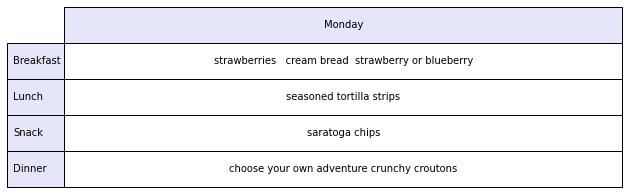

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 b
In which meal do you want us to make the change at (a,b,c,d) ? : 
 a)Breakfast 
 b)Lunch 
 c)Snack 
 d)Dinner 
 a
Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : 
 a)Yes,recommend this recipe again in the future 
 b)No,exclude it from future recommendations 
 a
Do you want to apply any filtering before the new recommendation (a,b) : 
 a)Yes,show me how 
 b)No 
 a
There are three filtering options to choose from, choose the one you want(a,b,c): 
 a)Keyword 
 b)Nutrition 
 c)Both 
   a
Enter the prefered keyword:  vegam
Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): 
 a)I want to apply a new filter in the recommendation 
 b)I dont want to apply a new filter in the recommendation but I still want yo

This is the modified meal plan for Monday


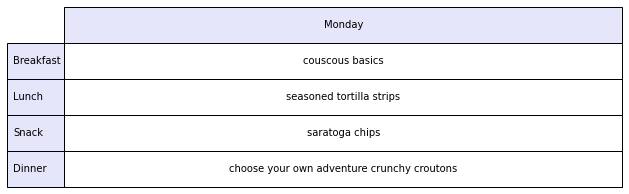

Are you satisfied or do you want to make some other change?(a,b) : 
 a)I want to make another change 
 b)I am satisfied with the meal plan lets proceed to the next day 
 b


This is our recommended meal plan for Tuesday


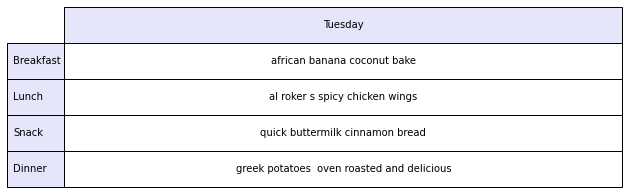

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 b
In which meal do you want us to make the change at (a,b,c,d) ? : 
 a)Breakfast 
 b)Lunch 
 c)Snack 
 d)Dinner 
 b
Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : 
 a)Yes,recommend this recipe again in the future 
 b)No,exclude it from future recommendations 
 b
Do you want to apply any filtering before the new recommendation (a,b) : 
 a)Yes,show me how 
 b)No 
 a
There are three filtering options to choose from, choose the one you want(a,b,c): 
 a)Keyword 
 b)Nutrition 
 c)Both 
   b
Enter your important nutrition(type the name of nutrition eg 'calories'): 
 a)calories 
 b)total fat (%) 
 c)sugar (%) 
 d)sodium (%) 
 e)protein (%) 
 f)saturated fat (%) 
 g)carbohydrates (%) 
 calories
Enter the nutrition value you want 200
Enter your preferce: 
 a)

This is the modified meal plan for Tuesday


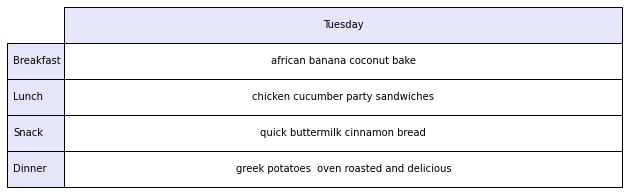

Are you satisfied or do you want to make some other change?(a,b) : 
 a)I want to make another change 
 b)I am satisfied with the meal plan lets proceed to the next day 
 b


This is our recommended meal plan for Wednesday


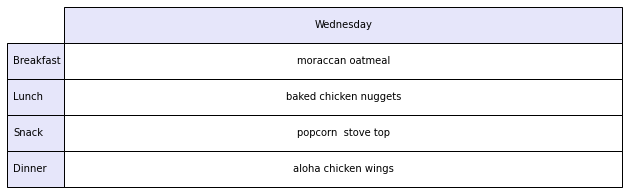

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Thursday


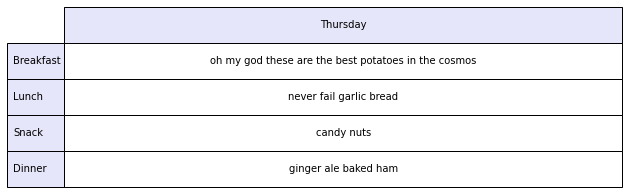

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Friday


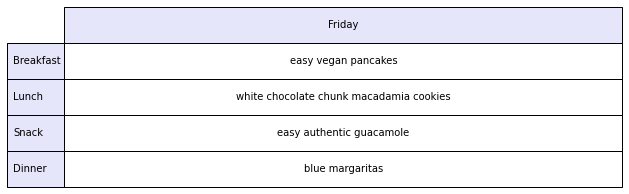

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Saturday


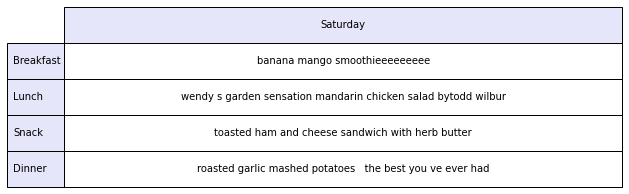

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Sunday


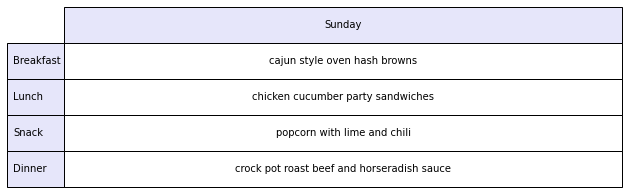

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


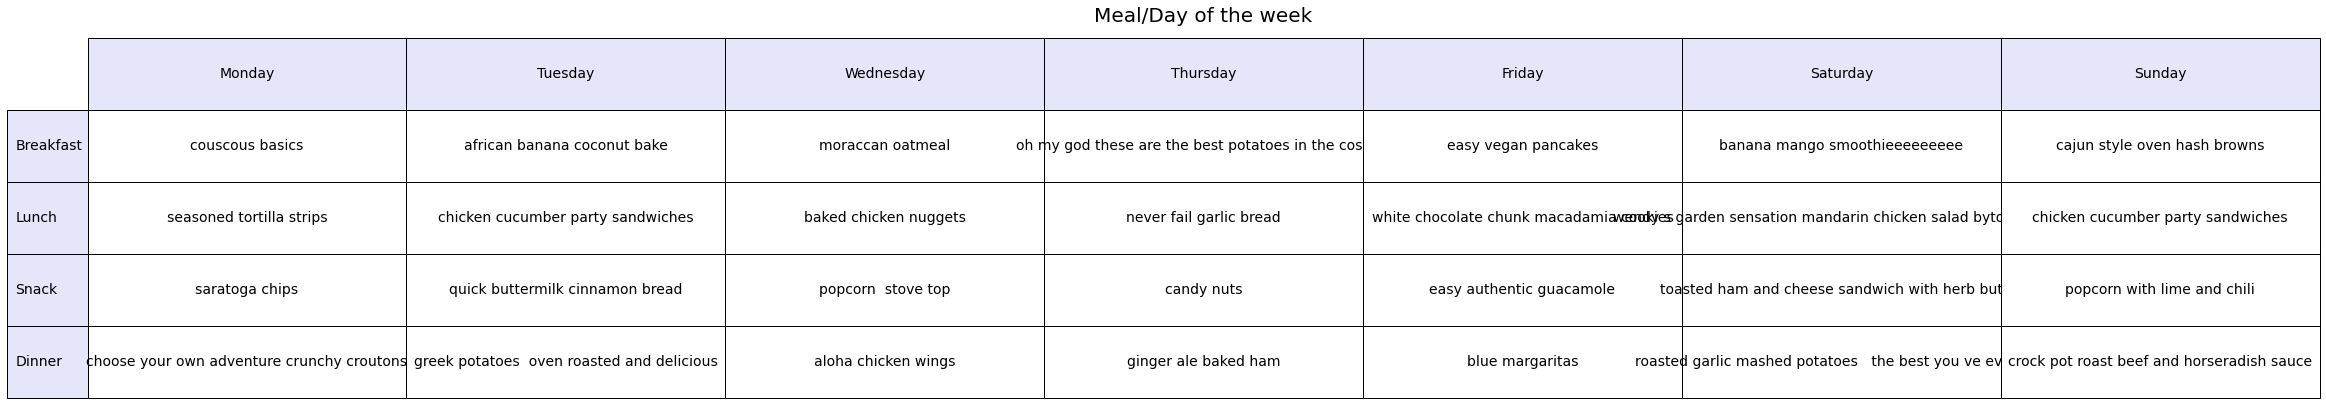

In [106]:
import matplotlib.pyplot as plt

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

print("Hey user "+str(user)+ ", together we will create a weekly meal plan suitable for your health condition(s) and adjusted to your personal preferences \n")

full_plan=np.empty((4,7), dtype=object)

excluded_breakfast=pd.DataFrame(columns=recipes_final.columns)
excluded_lunch=pd.DataFrame(columns=recipes_final.columns)
excluded_snack=pd.DataFrame(columns=recipes_final.columns)
excluded_dinner=pd.DataFrame(columns=recipes_final.columns)

withdrawal_breakfast=pd.DataFrame(columns=recipes_final.columns)
withdrawal_lunch=pd.DataFrame(columns=recipes_final.columns)
withdrawal_snack=pd.DataFrame(columns=recipes_final.columns)
withdrawal_dinner=pd.DataFrame(columns=recipes_final.columns)

excluded_breakfast=[]
excluded_lunch=[]
excluded_snack=[]
excluded_dinner=[]

withdrawal_breakfast=[]
withdrawal_lunch=[]
withdrawal_snack=[]
withdrawal_dinner=[]

count_excl_br=0
count_excl_lu=0
count_excl_sn=0
count_excl_di=0

count_with_br=0
count_with_lu=0
count_with_sn=0
count_with_di=0

or_rat_br=recipes_final_breakfast.copy()
or_rat_lu=recipes_final_lunch.copy()
or_rat_di=recipes_final_dinner.copy()
or_rat_sn=recipes_final_snack.copy()
weight=0
flag_dynamic_br=False
flag_dynamic_lu=False
flag_dynamic_sn=False
flag_dynamic_di=False

flag_dynamic_br_filt=False
flag_dynamic_lu_filt=False
flag_dynamic_sn_filt=False
flag_dynamic_di_filt=False

for i,day in enumerate(days_of_the_week):
    count_changes_breakfast=0
    count_changes_lunch=0
    count_changes_snack=0
    count_changes_dinner=0
    
    arr_day = np.empty((4,1), dtype=object)
    print("This is our recommended meal plan for "+day)
    arr_day[0]=recipes_final_breakfast['name'].iloc[0]
    arr_day[1]=recipes_final_lunch['name'].iloc[0]     
    arr_day[2]=recipes_final_snack['name'].iloc[0]
    arr_day[3]=recipes_final_dinner['name'].iloc[0]

    plt.rcParams["figure.figsize"] =[5, 1]
    fig, axs = plt.subplots(1, 1)
    rows = ("Breakfast","Lunch","Snack","Dinner")
    columns=day
    axs.axis('tight')
    axs.axis('off')
    the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
    the_table.scale(2,3)

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10) 
    #plt.title("Meal/Day of the week",y=4,fontsize=20) 
    plt.show()
    
    user_option = input("What do you want to do next (a,b,c) : \n a)It's ok for me,proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n") 
    
    if(user_option=='c'):
        while(user_option=='c'):
            
            meal_sel_info=input("About which meal do you want us to provide you with informations(a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            if(meal_sel_info=="a"):
                print("The recommended recipe for breakfast, names \""+ recipes_final_breakfast['name'].iloc[i]+"\", needs "+str(recipes_final_breakfast['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_breakfast['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_breakfast['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_breakfast['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_breakfast['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_breakfast['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_breakfast['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_breakfast['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_breakfast['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")       
            if(meal_sel_info=="b"):
                print("The recommended recipe for lunch, names \""+ recipes_final_lunch['name'].iloc[i]+"\", needs "+str(recipes_final_lunch['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_lunch['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_lunch['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_lunch['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_lunch['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_lunch['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_lunch['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_lunch['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_lunch['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="c"):
                print("The recommended recipe for snack, names \""+ recipes_final_snack['name'].iloc[i]+"\", needs "+str(recipes_final_snack['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_snack['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_snack['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_snack['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_snack['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_snack['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_snack['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_snack['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_snack['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="d"):
                print("The recommended recipe for dinner, names \""+ recipes_final_dinner['name'].iloc[i]+"\", needs "+str(recipes_final_dinner['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_dinner['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_dinner['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_dinner['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_dinner['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_dinner['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_dinner['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_dinner['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_dinner['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")


            next_option=input("Now after the informations about the recipe you saw,what do you want to do next (a,b,c) : \n a)Proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n")
            if(next_option=='a'):
                user_option='a'
            elif(next_option=='b'):
                user_option='b'
    
    if(user_option=='a'):
        if flag_dynamic_br ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)
                
        if flag_dynamic_br_filt ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu_filt ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn_filt ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di_filt ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  

        recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
        recipes_final_lunch=recipes_final_lunch.iloc[1:]
        recipes_final_snack=recipes_final_snack.iloc[1:]
        recipes_final_dinner=recipes_final_dinner.iloc[1:]
        
        full_plan[:,i]=arr_day[:,0]
    
    elif(user_option=='b'):
        exit_b = ''
        # this will loop until response is not "exit"
        while exit_b != 'b':
            meal_sel=input("In which meal do you want us to make the change at (a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            
            meal_exclude=input("Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : \n a)Yes,recommend this recipe again in the future \n b)No,exclude it from future recommendations \n")
            
            meal_filt=input("Do you want to apply any filtering before the new recommendation (a,b) : \n a)Yes,show me how \n b)No \n")
            
            
            if (meal_exclude=="b"):
                j=i 
                if(meal_sel=="a"):
                    #excluded_breakfast = pd.concat([excluded_breakfast, recipes_final_breakfast.head(1)], ignore_index=True)
                    #excluded_breakfast = excluded_breakfast.append(recipes_final_breakfast.head(1), ignore_index=True)
                    count_excl_br=count_excl_br+1
                    if(count_excl_br==1):
                        excluded_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                        recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                    else:
                        set1 = set(excluded_breakfast)
                        ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_breakfast_ingredients = set1.intersection(set2)
                        recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                        for index, row in recipes_final_breakfast.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                            if common_ingredients:
                                flag_dynamic_br=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                recipes_final_breakfast.loc[index, 'rating'] -= weight
                                recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    count_excl_lu=count_excl_lu+1
                    or_rat_lu=recipes_final_lunch.copy()
                    if(count_excl_lu==1):
                        excluded_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                        recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                    else:
                        set1 = set(excluded_lunch)
                        ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_lunch_ingredients = set1.intersection(set2)
                        recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                        for index, row in recipes_final_lunch.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                            if common_ingredients:
                                flag_dynamic_lu=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                recipes_final_lunch.loc[index, 'rating'] -= weight
                                recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                
                if(meal_sel=="c"):
                    count_excl_sn=count_excl_sn+1
                    if(count_excl_sn==1):
                        excluded_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                        recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                    else:
                        set1 = set(excluded_snack)
                        ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_snack_ingredients = set1.intersection(set2)
                        recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                        for index, row in recipes_final_snack.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                            if common_ingredients:
                                flag_dynamic_sn=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                recipes_final_snack.loc[index, 'rating'] -= weight
                                recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    count_excl_di=count_excl_di+1
                    or_rat_di=recipes_final_dinner.copy()
                    if(count_excl_di==1):
                        excluded_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                        recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                    else:
                        set1 = set(excluded_dinner)
                        ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_dinner_ingredients = set1.intersection(set2)
                        recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                        for index, row in recipes_final_dinner.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                            if common_ingredients:
                                flag_dynamic_di=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                recipes_final_dinner.loc[index, 'rating'] -= weight
                                recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
            elif (meal_exclude=="a"):
                j=i 
                if(meal_sel=="a"):
                    count_with_br=count_with_br+1
                    if(count_with_br==1):
                        withdrawal_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                    else:
                        set1 = set(withdrawal_breakfast)
                        ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_breakfast_ingredients = set1.intersection(set2)
                        #recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                        for index, row in recipes_final_breakfast.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                            if common_ingredients:
                                flag_dynamic_br=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                recipes_final_breakfast.loc[index, 'rating'] -= weight
                    recipes_final_breakfast.iloc[0, recipes_final_breakfast.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                    recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    count_with_lu=count_with_lu+1
                    or_rat_lu=recipes_final_lunch.copy()
                    if(count_with_lu==1):
                        withdrawal_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                    else:
                        set1 = set(withdrawal_lunch)
                        ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_lunch_ingredients = set1.intersection(set2)
                        #recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                        for index, row in recipes_final_lunch.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                            if common_ingredients:
                                flag_dynamic_lu=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                recipes_final_lunch.loc[index, 'rating'] -= weight
                    recipes_final_lunch.iloc[0, recipes_final_lunch.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                    recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                if(meal_sel=="c"):
                    count_with_sn=count_with_sn+1
                    or_rat_sn=recipes_final_snack.copy()
                    if(count_with_sn==1):
                        withdrawal_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                    else:
                        set1 = set(withdrawal_snack)
                        ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_snack_ingredients = set1.intersection(set2)
                        #recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                        for index, row in recipes_final_snack.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                            if common_ingredients:
                                flag_dynamic_sn=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                recipes_final_snack.loc[index, 'rating'] -= weight
                    recipes_final_snack.iloc[0, recipes_final_snack.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)                    
                    recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    count_with_di=count_with_di+1
                    if(count_with_di==1):
                        withdrawal_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                    else:
                        set1 = set(withdrawal_dinner)
                        ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                        set2 = set(ingredient_list)
                        intersection_dinner_ingredients = set1.intersection(set2)
                        #recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                        for index, row in recipes_final_dinner.iterrows():
                            ingredients_1 = eval(row['ingredients'])
                            common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                            if common_ingredients:
                                flag_dynamic_di=True
                                weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                recipes_final_dinner.loc[index, 'rating'] -= weight
                    recipes_final_dinner.iloc[0, recipes_final_dinner.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                    recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
                   
            fail_filt_input=''
            while fail_filt_input != 'b' and fail_filt_input != 'c' and fail_filt_input != "end" :
                #print("iiiii")
                if (meal_filt=="a"):
                    option=input("There are three filtering options to choose from, choose the one you want(a,b,c): \n a)Keyword \n b)Nutrition \n c)Both \n  ")
                    if(meal_sel=="a"):
                            recipes_breakfast_filtering=recipes_final_breakfast
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    
                                    flag_dynamic_br_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_breakfast.loc[recipes_final_breakfast['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                    
                                    
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[0]=recipes_breakfast_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="b"):
                            recipes_lunch_filtering=recipes_final_lunch
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    
                                    flag_dynamic_lu_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_lunch.loc[recipes_final_lunch['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[1]=recipes_lunch_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="c"):
                            recipes_snack_filtering=recipes_final_snack
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    
                                    flag_dynamic_sn_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    
                                    recipes_final_snack.loc[recipes_final_snack['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        
                                        
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[2]=recipes_snack_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="d"):    
                            recipes_dinner_filtering=recipes_final_dinner
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    
                                    flag_dynamic_di_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    
                                    recipes_final_dinner.loc[recipes_final_dinner['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[3]=recipes_dinner_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")
                if meal_filt=="b"or fail_filt_input=='b' :
                    j=i #check here if there is a problem
                    fail_filt_input = "end"
                    if(meal_sel=="a"):
                        arr_day[0]=recipes_final_breakfast['name'].iloc[0]
                    if(meal_sel=="b"):
                        arr_day[1]=recipes_final_lunch['name'].iloc[0]   
                    if(meal_sel=="c"):                
                        arr_day[2]=recipes_final_snack['name'].iloc[0]
                    if(meal_sel=="d"):
                        arr_day[3]=recipes_final_dinner['name'].iloc[0]
            print("This is the modified meal plan for "+day)            
            
            plt.rcParams["figure.figsize"] =[5, 1]
            fig, axs = plt.subplots(1, 1)
            rows = ("Breakfast","Lunch","Snack","Dinner")
            axs.axis('tight')
            axs.axis('off')
            the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
            the_table.scale(2,3)

            the_table.auto_set_font_size(False)
            the_table.set_fontsize(10) 
            #plt.title("Meal/Day of the week",y=4,fontsize=20) 
            plt.show()
            
            exit_b=input("Are you satisfied or do you want to make some other change?(a,b) : \n a)I want to make another change \n b)I am satisfied with the meal plan lets proceed to the next day \n")
            
            if(exit_b=="b"):
                if flag_dynamic_br ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)               
                
                if flag_dynamic_br_filt ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu_filt ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn_filt ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di_filt ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  
                
                
                
                full_plan[:,i]=arr_day[:,0]
                recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
                recipes_final_lunch=recipes_final_lunch.iloc[1:]
                recipes_final_snack=recipes_final_snack.iloc[1:]
                recipes_final_dinner=recipes_final_dinner.iloc[1:]


plt.rcParams["figure.figsize"] =[20, 1]
fig, axs = plt.subplots(1, 1)
columns = ("Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
rows = ("Breakfast","Lunch","Snack","Dinner")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=full_plan,cellLoc="center", colLabels=columns,rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
the_table.scale(2,6)

the_table.auto_set_font_size(False)
the_table.set_fontsize(14) 
plt.title("Meal/Day of the week",y=4,fontsize=20) 
plt.show()

In [130]:
set1 = set(excluded_breakfast)
ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
set2 = set(ingredient_list)
intersection = set1.intersection(set2)

set

In [107]:
#create dataframes for each chronic disease that include the tags we are about to use to recommend recipes  
cancer = pd.DataFrame({'high-protein', 'high-fiber', 'low-saturated-fat', 'low-sodium'})
obesity = pd.DataFrame({'high-protein', 'low-fat', 'low-saturated-fat', 'low-calorie','high-calcium','low-carb'})
diabetes = pd.DataFrame({'diabetic'})
heart = pd.DataFrame({'high-protein', 'high-fiber', 'low-saturated-fat', 'low-sodium','low-cholesterol','low-carb'})
dental = pd.DataFrame({'high-protein', 'high-fiber','low-sodium','low-carb','high-calcium'})
osteoporosis = pd.DataFrame({'high-protein', 'high-calcium', 'low-saturated-fat', 'low-sodium'})
diab=False

In [108]:
#count how many diseases the user has
count_diseases=users_health.loc[user].value_counts().get(True, 0)
if users_health.loc[user].value_counts('Diabetes').get(True, 0)==1:
    diab=True
    count_diseases=count_diseases-1

In [109]:
#create the user health profile 
health_history_df=pd.DataFrame({})
for_explanation_print_diseases=''
if users_health.loc[user,'Cancer']:
    health_history_df=pd.concat([health_history_df, cancer], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Cancer patient,'
    
if users_health.loc[user,'Obesity']:
    health_history_df=pd.concat([health_history_df, obesity], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Obese,'
    
if users_health.loc[user,'Diabetes']:
    health_history_df=pd.concat([health_history_df, diabetes], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Diabetic,'

if users_health.loc[user,'Cardiovascular']:
    health_history_df=pd.concat([health_history_df, heart], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Ηeart patient,'

if users_health.loc[user,'Dental']:
    health_history_df=pd.concat([health_history_df, dental], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Dental patient,'

if users_health.loc[user,'Osteoporosis']:
    health_history_df=pd.concat([health_history_df, osteoporosis], ignore_index=True)
    for_explanation_print_diseases=for_explanation_print_diseases+'Osteoporosis patient,'

if count_diseases==0:
    for_explanation_print_diseases='Healthy user'

aa


3

In [111]:
#users_health.loc[user]

Cancer            False
Obesity            True
Diabetes           True
Cardiovascular     True
Dental            False
Osteoporosis      False
Name: 1689705, dtype: bool

In [122]:
#health_history_df

,tag,occurrences
3,low-carb,2
4,low-saturated-fat,2
5,high-protein,2


In [113]:
#when the user has chronic disease
if not health_history_df.empty:
    health_history_df = health_history_df.rename(columns={0: 'tag'})
    health_history_df['occurrences'] = health_history_df.groupby('tag')['tag'].transform('count')
    health_history_df=health_history_df.drop_duplicates().sort_values(by='occurrences', ascending=False)
    #edw einai se sxolio giati se kapoies periptwseis den ypirxan alla fagita opote ekana pio elastiko to periorismo twn tags
    
    while(health_history_df[health_history_df['occurrences'] == count_diseases].empty):
        count_diseases=count_diseases-1
    health_history_df=health_history_df[health_history_df['occurrences'] == count_diseases]
    
    if diab==True:
        health_history_df=health_history_df.append({'tag':'diabetic'}, ignore_index = True)

    for x in health_history_df['tag'].astype(str).tolist():
        health_recipes_final_filtering_final=recipes_final[recipes_final[x]==True]

    if diab==True:
        health_recipes_final_filtering_final=recipes_final[recipes_final['diabetic']==True]


In [114]:
#health_history_df

,tag,occurrences
3,low-carb,2
4,low-saturated-fat,2
5,high-protein,2


In [116]:
recipes_final_breakfast = health_recipes_final_filtering_final[health_recipes_final_filtering_final['breakfast'] == True]
recipes_final_lunch = health_recipes_final_filtering_final[health_recipes_final_filtering_final['lunch'] == True]
recipes_final_snack = health_recipes_final_filtering_final[health_recipes_final_filtering_final['snacks'] == True]
recipes_final_dinner = health_recipes_final_filtering_final[health_recipes_final_filtering_final['dinner'] == True]

In [118]:
flag_br=False
flag_lu=False
flag_sn=False
flag_di=False

if(len(recipes_final_breakfast)<10):
    flag_br=True
    br_len=len(recipes_final_breakfast)
    recipes_final_breakfast=pd.concat([recipes_final_breakfast] * 10, ignore_index=True)
if(len(recipes_final_lunch)<10):
    lu_len=len(recipes_final_lunch)
    flag_lu=True
    recipes_final_lunch=pd.concat([recipes_final_lunch] * 10, ignore_index=True)
if(len(recipes_final_snack)<10):
    sn_len=len(recipes_final_snack)
    flag_sn=True
    recipes_final_snack=pd.concat([recipes_final_snack] * 10, ignore_index=True)
if(len(recipes_final_dinner)<10):
    di_len=len(recipes_final_dinner)
    flag_di=True
    recipes_final_dinner=pd.concat([recipes_final_dinner] * 10, ignore_index=True)

Hey user 1689705, together we will create a weekly meal plan suitable for your health condition(s) and adjusted to your personal preferences 

This is our recommended meal plan for Monday


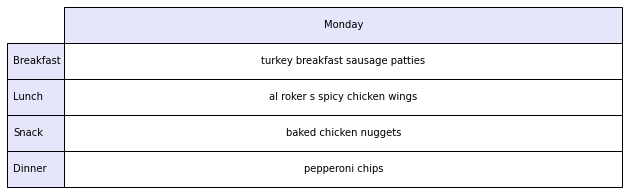

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 b
In which meal do you want us to make the change at (a,b,c,d) ? : 
 a)Breakfast 
 b)Lunch 
 c)Snack 
 d)Dinner 
 a
Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : 
 a)Yes,recommend this recipe again in the future 
 b)No,exclude it from future recommendations 
 b
Do you want to apply any filtering before the new recommendation (a,b) : 
 a)Yes,show me how 
 b)No 
 a
Be aware of the fact that there are only 2 possible breakfast recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : 
 a)Yes 
 b)No 
 a
There are three filtering options to choose from, choose the one you want(a,b,c): 
 a)Keyword 
 b)Nutrition 
 c)Both 
   b
Enter your important nutrition(type the name of nutrition eg 'calories

This is the modified meal plan for Monday


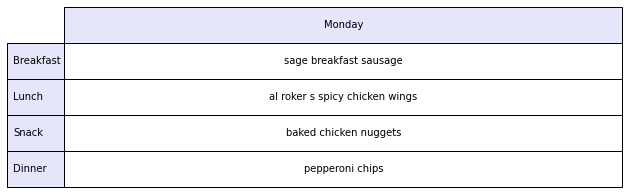

Are you satisfied or do you want to make some other change?(a,b) : 
 a)I want to make another change 
 b)I am satisfied with the meal plan lets proceed to the next day 
 b


This is our recommended meal plan for Tuesday


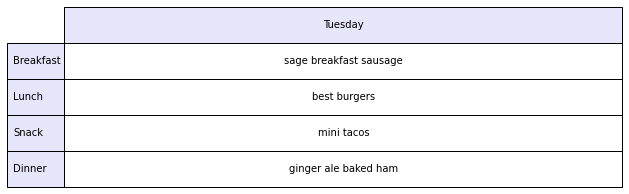

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Wednesday


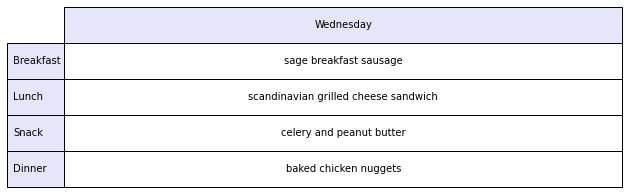

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Thursday


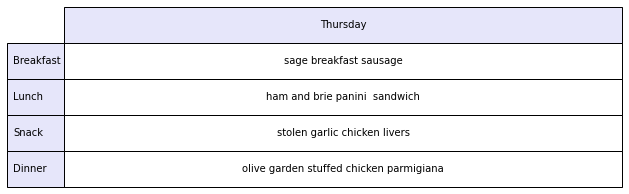

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 b
In which meal do you want us to make the change at (a,b,c,d) ? : 
 a)Breakfast 
 b)Lunch 
 c)Snack 
 d)Dinner 
 d
Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : 
 a)Yes,recommend this recipe again in the future 
 b)No,exclude it from future recommendations 
 b
Do you want to apply any filtering before the new recommendation (a,b) : 
 a)Yes,show me how 
 b)No 
 b


This is the modified meal plan for Thursday


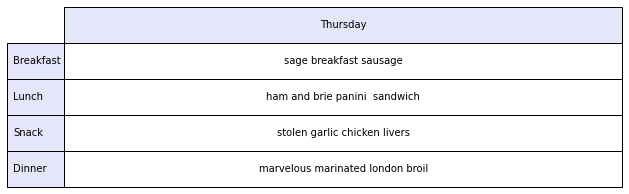

Are you satisfied or do you want to make some other change?(a,b) : 
 a)I want to make another change 
 b)I am satisfied with the meal plan lets proceed to the next day 
 b


This is our recommended meal plan for Friday


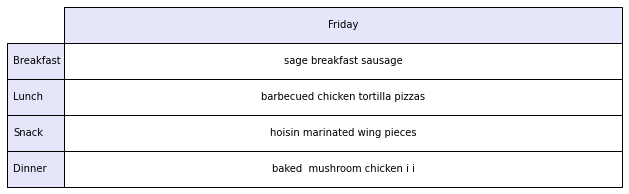

What do you want to do next (a,b,c) : 
 a)It's ok for me,proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 c
About which meal do you want us to provide you with informations(a,b,c,d) ? : 
 a)Breakfast 
 b)Lunch 
 c)Snack 
 d)Dinner 
 a


The recommended recipe for breakfast, names "sage breakfast sausage", needs 30 minutes of cooking time, needs also 6 ingredients. The recipe has 200.5 calories,  24.0 total fat (%),  0.0 sugar (%),  17.0 sodium (%),  25.0 protein (%),  0.0 carbohydrates (%),  29.0 saturated fat (%) 



Now after the informations about the recipe you saw,what do you want to do next (a,b,c) : 
 a)Proceed to the next day 
 b)I want you to change the menu for a meal 
 c)I want more informations about a meal 
 a


This is our recommended meal plan for Saturday


IndexError: single positional indexer is out-of-bounds

In [120]:
import matplotlib.pyplot as plt

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

print("Hey user "+str(user)+ ", together we will create a weekly meal plan suitable for your health condition(s) and adjusted to your personal preferences \n")

full_plan=np.empty((4,7), dtype=object)

excluded_breakfast=pd.DataFrame(columns=recipes_final.columns)
excluded_lunch=pd.DataFrame(columns=recipes_final.columns)
excluded_snack=pd.DataFrame(columns=recipes_final.columns)
excluded_dinner=pd.DataFrame(columns=recipes_final.columns)

withdrawal_breakfast=pd.DataFrame(columns=recipes_final.columns)
withdrawal_lunch=pd.DataFrame(columns=recipes_final.columns)
withdrawal_snack=pd.DataFrame(columns=recipes_final.columns)
withdrawal_dinner=pd.DataFrame(columns=recipes_final.columns)

excluded_breakfast=[]
excluded_lunch=[]
excluded_snack=[]
excluded_dinner=[]

withdrawal_breakfast=[]
withdrawal_lunch=[]
withdrawal_snack=[]
withdrawal_dinner=[]

count_excl_br=0
count_excl_lu=0
count_excl_sn=0
count_excl_di=0

count_with_br=0
count_with_lu=0
count_with_sn=0
count_with_di=0

or_rat_br=recipes_final_breakfast.copy()
or_rat_lu=recipes_final_lunch.copy()
or_rat_di=recipes_final_dinner.copy()
or_rat_sn=recipes_final_snack.copy()
weight=0
flag_dynamic_br=False
flag_dynamic_lu=False
flag_dynamic_sn=False
flag_dynamic_di=False

flag_dynamic_br_filt=False
flag_dynamic_lu_filt=False
flag_dynamic_sn_filt=False
flag_dynamic_di_filt=False


for i,day in enumerate(days_of_the_week):
    count_changes_breakfast=0
    count_changes_lunch=0
    count_changes_snack=0
    count_changes_dinner=0
    
    arr_day = np.empty((4,1), dtype=object)
    print("This is our recommended meal plan for "+day)
    arr_day[0]=recipes_final_breakfast['name'].iloc[i]
    arr_day[1]=recipes_final_lunch['name'].iloc[i]     
    arr_day[2]=recipes_final_snack['name'].iloc[i]
    arr_day[3]=recipes_final_dinner['name'].iloc[i]

    plt.rcParams["figure.figsize"] =[5, 1]
    fig, axs = plt.subplots(1, 1)
    rows = ("Breakfast","Lunch","Snack","Dinner")
    columns=day
    axs.axis('tight')
    axs.axis('off')
    the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
    the_table.scale(2,3)

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10) 
    #plt.title("Meal/Day of the week",y=4,fontsize=20) 
    plt.show()
    
    user_option = input("What do you want to do next (a,b,c) : \n a)It's ok for me,proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n") 
    
    if(user_option=='c'):
        while(user_option=='c'):
            
            meal_sel_info=input("About which meal do you want us to provide you with informations(a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            if(meal_sel_info=="a"):
                print("The recommended recipe for breakfast, names \""+ recipes_final_breakfast['name'].iloc[i]+"\", needs "+str(recipes_final_breakfast['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_breakfast['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_breakfast['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_breakfast['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_breakfast['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_breakfast['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_breakfast['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_breakfast['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_breakfast['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")       
            if(meal_sel_info=="b"):
                print("The recommended recipe for lunch, names \""+ recipes_final_lunch['name'].iloc[i]+"\", needs "+str(recipes_final_lunch['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_lunch['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_lunch['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_lunch['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_lunch['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_lunch['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_lunch['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_lunch['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_lunch['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="c"):
                print("The recommended recipe for snack, names \""+ recipes_final_snack['name'].iloc[i]+"\", needs "+str(recipes_final_snack['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_snack['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_snack['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_snack['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_snack['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_snack['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_snack['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_snack['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_snack['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")
            if(meal_sel_info=="d"):
                print("The recommended recipe for dinner, names \""+ recipes_final_dinner['name'].iloc[i]+"\", needs "+str(recipes_final_dinner['minutes'].iloc[i]) + " minutes of cooking time, needs also "
                      +str(recipes_final_dinner['n_ingredients'].iloc[i])+" ingredients. The recipe has "+str(recipes_final_dinner['calories'].iloc[i]) + " calories, "
                      +str(recipes_final_dinner['total fat (%)'].iloc[i])  + " total fat (%), " +str(recipes_final_dinner['sugar (%)'].iloc[i])  + " sugar (%), "
                      +str(recipes_final_dinner['sodium (%)'].iloc[i])  + " sodium (%), " +str(recipes_final_dinner['protein (%)'].iloc[i])  + " protein (%), "
                      +str(recipes_final_dinner['carbohydrates (%)'].iloc[i])  + " carbohydrates (%), " +str(recipes_final_dinner['saturated fat (%)'].iloc[i])  + " saturated fat (%) \n")


            next_option=input("Now after the informations about the recipe you saw,what do you want to do next (a,b,c) : \n a)Proceed to the next day \n b)I want you to change the menu for a meal \n c)I want more informations about a meal \n")
            if(next_option=='a'):
                user_option='a'
            elif(next_option=='b'):
                user_option='b'
    
    if(user_option=='a'):
        if flag_dynamic_br ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)
                
        if flag_dynamic_br_filt ==True:
            for index, row in recipes_final_breakfast.iterrows():
                recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_lu_filt ==True:
            for index, row in recipes_final_lunch.iterrows():
                recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_sn_filt ==True:
            for index, row in recipes_final_snack.iterrows():
                recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
        if flag_dynamic_di_filt ==True:
            for index, row in recipes_final_dinner.iterrows():
                recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  

        full_plan[:,i]=arr_day[:,0]
        recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
        recipes_final_lunch=recipes_final_lunch.iloc[1:]
        recipes_final_snack=recipes_final_snack.iloc[1:]
        recipes_final_dinner=recipes_final_dinner.iloc[1:]
    
    elif(user_option=='b'):      
        exit_b = ''
        # this will loop until response is not "exit"
        while exit_b != 'b':
            meal_sel=input("In which meal do you want us to make the change at (a,b,c,d) ? : \n a)Breakfast \n b)Lunch \n c)Snack \n d)Dinner \n")
            
            meal_exclude=input("Do you want us to recommend this recipe again in the future or to exclude it from our recommendations to you? (a,b) : \n a)Yes,recommend this recipe again in the future \n b)No,exclude it from future recommendations \n")
            
            meal_filt=input("Do you want to apply any filtering before the new recommendation (a,b) : \n a)Yes,show me how \n b)No \n")
            
            
            if (meal_exclude=="b"):
                j=i #check here if there is a problem
                if(meal_sel=="a"):
                    if(flag_br==True):
                        if(br_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(br_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible breakfast recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_breakfast=recipes_final_breakfast[~((recipes_final_breakfast['name'] == recipes_final_breakfast.iloc[0]['name']) & (recipes_final_breakfast.duplicated(subset='name', keep=False)))]
                                recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                                br_len=br_len-1
                    else:
                        count_excl_br=count_excl_br+1
                        if(count_excl_br==1):
                            excluded_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                            recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                        else:
                            set1 = set(excluded_breakfast)
                            ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_breakfast_ingredients = set1.intersection(set2)
                            recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                            for index, row in recipes_final_breakfast.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                                if common_ingredients:
                                    flag_dynamic_br=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_breakfast.loc[index, 'rating'] -= weight
                                    recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    if(flag_lu==True):
                        if(lu_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(lu_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible lunch recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_lunch=recipes_final_lunch[~((recipes_final_lunch['name'] == recipes_final_lunch.iloc[0]['name']) & (recipes_final_lunch.duplicated(subset='name', keep=False)))]
                                recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                                lu_len=lu_len-1
                    else:
                        count_excl_lu=count_excl_lu+1
                        if(count_excl_lu==1):
                            excluded_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                            recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                        else:
                            set1 = set(excluded_lunch)
                            ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_lunch_ingredients = set1.intersection(set2)
                            recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                            for index, row in recipes_final_lunch.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                                if common_ingredients:
                                    flag_dynamic_lu=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_lunch.loc[index, 'rating'] -= weight
                                    recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                if(meal_sel=="c"):
                    if(flag_sn==True):
                        if(sn_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(sn_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible snack recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):
                                recipes_final_snack=recipes_final_snack[~((recipes_final_snack['name'] == recipes_final_snack.iloc[0]['name']) & (recipes_final_snack.duplicated(subset='name', keep=False)))]
                                recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                                sn_len=sn_len-1
                    else:
                        count_excl_sn=count_excl_sn+1
                        if(count_excl_sn==1):
                            excluded_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                            recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                        else:
                            set1 = set(excluded_snack)
                            ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_snack_ingredients = set1.intersection(set2)
                            recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                            for index, row in recipes_final_snack.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                                if common_ingredients:
                                    flag_dynamic_sn=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_snack.loc[index, 'rating'] -= weight
                                    recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    if(flag_di==True):
                        if(di_len==1):
                            print("Sorry this is the only possible recipe for you. You can't exclude it.\n")
                        elif(di_len < 4):
                            drop_sel=input("Be aware of the fact that there are only "+ str(br_len)+" possible dinner recipes left before you exclude this recipe from future recommendations. Are you sure you want to continue? (a,b) ? : \n a)Yes \n b)No \n")
                            if(drop_sel=='a'):    
                                recipes_final_dinner=recipes_final_dinner[~((recipes_final_dinner['name'] == recipes_final_dinner.iloc[0]['name']) & (recipes_final_dinner.duplicated(subset='name', keep=False)))]
                                recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                                di_len=di_len-1
                    else:
                        count_excl_di=count_excl_di+1
                        if(count_excl_di==1):
                            excluded_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                            recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                        else:
                            set1 = set(excluded_dinner)
                            ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_dinner_ingredients = set1.intersection(set2)
                            recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                            for index, row in recipes_final_dinner.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                                if common_ingredients:
                                    flag_dynamic_di=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 3)
                                    recipes_final_dinner.loc[index, 'rating'] -= weight
                                    recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
            elif (meal_exclude=="a"):
                j=i #check here if there is a problem
                if(meal_sel=="a"):
                    if(flag_br==True):
                        if(br_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_breakfast = recipes_final_breakfast.shift(-1)
                            recipes_final_breakfast.iloc[-1] = recipes_final_breakfast.iloc[0] 
                    else:
                        count_with_br=count_with_br+1
                        if(count_with_br==1):
                            withdrawal_breakfast.extend(ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_breakfast)
                            ingredient_list = ast.literal_eval(recipes_final_breakfast.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_breakfast_ingredients = set1.intersection(set2)
                            #recipes_final_breakfast=recipes_final_breakfast.drop(recipes_final_breakfast.head(1).index)
                            for index, row in recipes_final_breakfast.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_breakfast_ingredients)
                                if common_ingredients:
                                    flag_dynamic_br=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_breakfast.loc[index, 'rating'] -= weight
                        recipes_final_breakfast.iloc[0, recipes_final_breakfast.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_breakfast=recipes_final_breakfast.sort_values(by='rating',ascending=False)
                if(meal_sel=="b"):
                    if(flag_lu==True):
                        if(lu_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_lunch = recipes_final_lunch.shift(-1)
                            recipes_final_lunch.iloc[-1] = recipes_final_lunch.iloc[0] 
                    else:
                        count_with_lu=count_with_lu+1
                        if(count_with_lu==1):
                            withdrawal_lunch.extend(ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_lunch)
                            ingredient_list = ast.literal_eval(recipes_final_lunch.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_lunch_ingredients = set1.intersection(set2)
                            #recipes_final_lunch=recipes_final_lunch.drop(recipes_final_lunch.head(1).index)
                            for index, row in recipes_final_lunch.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_lunch_ingredients)
                                if common_ingredients:
                                    flag_dynamic_lu=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_lunch.loc[index, 'rating'] -= weight
                        recipes_final_lunch.iloc[0, recipes_final_lunch.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_lunch=recipes_final_lunch.sort_values(by='rating',ascending=False)
                if(meal_sel=="c"):
                    if(flag_sn==True):
                        if(sn_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_snack = recipes_final_snack.shift(-1)
                            recipes_final_snack.iloc[-1] = recipes_final_snack.iloc[0] 
                    else:
                        count_with_sn=count_with_sn+1
                        if(count_with_sn==1):
                            withdrawal_snack.extend(ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_snack)
                            ingredient_list = ast.literal_eval(recipes_final_snack.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_snack_ingredients = set1.intersection(set2)
                            #recipes_final_snack=recipes_final_snack.drop(recipes_final_snack.head(1).index)
                            for index, row in recipes_final_snack.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_snack_ingredients)
                                if common_ingredients:
                                    flag_dynamic_sn=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_snack.loc[index, 'rating'] -= weight
                        recipes_final_snack.iloc[0, recipes_final_snack.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)                    
                        recipes_final_snack=recipes_final_snack.sort_values(by='rating',ascending=False)
                if(meal_sel=="d"):
                    if(flag_di==True):
                        if(di_len==1):
                            print("Sorry this is the only possible recipe for you. You can't alter it.\n")
                        else:
                            recipes_final_dinner = recipes_final_dinner.shift(-1)
                            recipes_final_dinner.iloc[-1] = recipes_final_dinner.iloc[0] 
                    else:
                        count_with_di=count_with_di+1
                        if(count_with_di==1):
                            withdrawal_dinner.extend(ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0]))
                        else:
                            set1 = set(withdrawal_dinner)
                            ingredient_list = ast.literal_eval(recipes_final_dinner.head(1)['ingredients'].values[0])
                            set2 = set(ingredient_list)
                            intersection_dinner_ingredients = set1.intersection(set2)
                            #recipes_final_dinner=recipes_final_dinner.drop(recipes_final_dinner.head(1).index)
                            for index, row in recipes_final_dinner.iterrows():
                                ingredients_1 = eval(row['ingredients'])
                                common_ingredients = set(ingredients_1).intersection(intersection_dinner_ingredients)
                                if common_ingredients:
                                    flag_dynamic_di=True
                                    weight=len(common_ingredients) * round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.01, 4)
                                    recipes_final_dinner.loc[index, 'rating'] -= weight                        
                        recipes_final_dinner.iloc[0, recipes_final_dinner.columns.get_loc('rating')] -= (round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)/2)
                        recipes_final_dinner=recipes_final_dinner.sort_values(by='rating',ascending=False)
                
                
            fail_filt_input=''
            while fail_filt_input != 'b' and fail_filt_input != 'c' and fail_filt_input != "end" :
                #print("iiiii")
                if (meal_filt=="a"):
                    option=input("There are three filtering options to choose from, choose the one you want(a,b,c): \n a)Keyword \n b)Nutrition \n c)Both \n  ")
                    if(meal_sel=="a"):
                            recipes_breakfast_filtering=recipes_final_breakfast
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_br_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_breakfast.loc[recipes_final_breakfast['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                    
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_breakfast_filtering=recipes_breakfast_filtering[recipes_breakfast_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_br_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_breakfast.loc[recipes_final_breakfast[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[0]=recipes_breakfast_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="b"):
                            recipes_lunch_filtering=recipes_final_lunch
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x)]

                                    flag_dynamic_lu_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_lunch.loc[recipes_lunch_filtering['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)<=num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)                                        
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_lunch_filtering=recipes_lunch_filtering[recipes_lunch_filtering[pref_nutr].astype(float)>num_input]
                                        
                                        flag_dynamic_lu_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        
                                        recipes_final_lunch.loc[recipes_final_lunch[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[1]=recipes_lunch_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="c"):
                            recipes_snack_filtering=recipes_final_snack
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_sn_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_snack.loc[recipes_final_snack['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_snack_filtering=recipes_snack_filtering[recipes_snack_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_sn_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_snack.loc[recipes_final_snack[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[2]=recipes_snack_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")

                    if(meal_sel=="d"):    
                            recipes_dinner_filtering=recipes_final_dinner
                            keyw_flag=False
                            nutr_flag=False
                            if option=='a' or option=='c' :
                                pref_keyword = input("Enter the prefered keyword: ") #asking for user to give his prefered tag/keyword
                                if any(recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)):
                                    recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering['tags'].apply(lambda x: pref_keyword in x)]
                                    flag_dynamic_di_filt=True
                                    weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                    recipes_final_dinner.loc[recipes_final_dinner['tags'].apply(lambda x: pref_keyword in x), 'rating'] +=weight
                                    fail_filt_input="end"
                                else:
                                    keyw_flag=True

                            if option=='b' or option=='c':
                                pref_nutr = input("Enter your important nutrition(type the name of nutrition eg 'calories'): \n a)calories \n b)total fat (%) \n c)sugar (%) \n d)sodium (%) \n e)protein (%) \n f)saturated fat (%) \n g)carbohydrates (%) \n") #asking for user to give his important nutrition

                                num_input= float(input("Enter the nutrition value you want")) 

                                comparison = input("Enter your preferce: \n a)less or equal than nutrition value \n b)greater than nutrition value \n") 

                                if(comparison=='a'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input].empty:   
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)<=num_input]
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)<=num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True
                                elif(comparison=='b'):
                                    if not recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input].empty:
                                        recipes_dinner_filtering=recipes_dinner_filtering[recipes_dinner_filtering[pref_nutr].astype(float)>num_input]
                                        flag_dynamic_di_filt=True
                                        weight=round(Mean.loc[Mean['user_id'] == user, 'rating'].iloc[0] % 0.1, 4)
                                        recipes_final_dinner.loc[recipes_final_dinner[pref_nutr].astype(float)>num_input, 'rating'] +=weight
                                        fail_filt_input="end"
                                    else:
                                        nutr_flag=True

                            if(keyw_flag==False and nutr_flag==False):
                                arr_day[3]=recipes_dinner_filtering['name'].iloc[i]
                            else:
                                fail_filt_input= input("Sorry there are no recipes matching the applied filter criteria.What do you want to do next(a,b,c): \n a)I want to apply a new filter in the recommendation \n b)I dont want to apply a new filter in the recommendation but I still want you to recommend me a new recipe\n ")
                if meal_filt=="b"or fail_filt_input=='b' :
                    j=i #check here if there is a problem
                    fail_filt_input = "end"
                    if(meal_sel=="a"):
                        arr_day[0]=recipes_final_breakfast['name'].iloc[i]
                    if(meal_sel=="b"):
                        arr_day[1]=recipes_final_lunch['name'].iloc[i]   
                    if(meal_sel=="c"):                
                        arr_day[2]=recipes_final_snack['name'].iloc[i]
                    if(meal_sel=="d"):
                        arr_day[3]=recipes_final_dinner['name'].iloc[i]
            print("This is the modified meal plan for "+day)            
            
            plt.rcParams["figure.figsize"] =[5, 1]
            fig, axs = plt.subplots(1, 1)
            rows = ("Breakfast","Lunch","Snack","Dinner")
            axs.axis('tight')
            axs.axis('off')
            the_table = axs.table(cellText=arr_day,cellLoc="center", colLabels=[day.strip() for day1 in day],rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
            the_table.scale(2,3)

            the_table.auto_set_font_size(False)
            the_table.set_fontsize(10) 
            #plt.title("Meal/Day of the week",y=4,fontsize=20) 
            plt.show()
            
            exit_b=input("Are you satisfied or do you want to make some other change?(a,b) : \n a)I want to make another change \n b)I am satisfied with the meal plan lets proceed to the next day \n")
            
            if(exit_b=="b"):
                if flag_dynamic_br ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] +=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] +=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] +=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] +=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)               
                
                if flag_dynamic_br_filt ==True:
                    for index, row in recipes_final_breakfast.iterrows():
                        recipes_final_breakfast.loc[index, 'rating'] -=(or_rat_br.loc[index, 'rating']-recipes_final_breakfast.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_lu_filt ==True:
                    for index, row in recipes_final_lunch.iterrows():
                        recipes_final_lunch.loc[index, 'rating'] -=(or_rat_lu.loc[index, 'rating']-recipes_final_lunch.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_sn_filt ==True:
                    for index, row in recipes_final_snack.iterrows():
                        recipes_final_snack.loc[index, 'rating'] -=(or_rat_sn.loc[index, 'rating']-recipes_final_snack.loc[index, 'rating'])/(7-i+1)
                if flag_dynamic_di_filt ==True:
                    for index, row in recipes_final_dinner.iterrows():
                        recipes_final_dinner.loc[index, 'rating'] -=(or_rat_di.loc[index, 'rating']-recipes_final_dinner.loc[index, 'rating'])/(7-i+1)  
                
                
                
                full_plan[:,i]=arr_day[:,0]
                recipes_final_breakfast=recipes_final_breakfast.iloc[1:]
                recipes_final_lunch=recipes_final_lunch.iloc[1:]
                recipes_final_snack=recipes_final_snack.iloc[1:]
                recipes_final_dinner=recipes_final_dinner.iloc[1:]


plt.rcParams["figure.figsize"] =[20, 1]
fig, axs = plt.subplots(1, 1)
columns = ("Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
rows = ("Breakfast","Lunch","Snack","Dinner")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=full_plan,cellLoc="center", colLabels=columns,rowLabels=rows, loc='center',colColours=np.full(len(columns), 'lavender'),rowColours=np.full(len(rows), 'lavender'))
the_table.scale(2,6)

the_table.auto_set_font_size(False)
the_table.set_fontsize(14) 
plt.title("Meal/Day of the week",y=4,fontsize=20) 
plt.show()

In [ ]:
'''
df = pd.read_csv("RAW_recipes.csv",encoding="Latin1")

tags_column = df['tags']

all_tags = []

for tags in tags_column:
    all_tags.extend(eval(tags))

tag_counts = pd.Series(all_tags).value_counts()

tag_counts_df = pd.DataFrame({'Tag': tag_counts.index, 'Count': tag_counts.values})

tag_counts_df.to_excel('tag_counts.xlsx', index=False)
'''

In [30]:
'''

df = pd.read_csv("RAW_recipes.csv",encoding="Latin1")

ingredients_column = df['ingredients']

all_ingredients = []

for ingredients in ingredients_column:
    all_ingredients.extend(eval(ingredients))

ingredients_counts = pd.Series(all_ingredients).value_counts()

ingredients_counts_df = pd.DataFrame({'Ingredient': tag_counts.index, 'Count': tag_counts.values})

ingredients_counts_df.to_excel('ingredients_counts.xlsx', index=False)
'''